In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import keras
import os
import shutil
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Reshape, Permute, GRU, BatchNormalization, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetB5, InceptionV3
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
train_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/train'
test_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/test'
valid_path=r'/content/drive/MyDrive/Knee_Osteoarthritis_Dataset_Preprocessed/validation'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)


train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173


In [ ]:
drop_classes = ['Doubtful', 'Minimal']

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')
for label in list_of_classes:
    group = groups.get_group(label)
    print(label, len(group))

Healthy 2286
Moderate 757
Severe 173


In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=2500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  3216
Found 2286 validated image filenames.
Found 173 validated image filenames.
Found 757 validated image filenames.
Total Augmented images created=  4284
Length of augmented dataframe is now  7500


In [ ]:
batch_size=32 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 7500 validated image filenames belonging to 3 classes.
Found 461 validated image filenames belonging to 3 classes.
Found 913 validated image filenames belonging to 3 classes.
test batch size:  11   test steps:  83  number of classes :  3


In [ ]:


# Function to create base models
def create_model(base_model):
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    return model

# Recreate the base models
base_model1 = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model2 = EfficientNetB5(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)


# Load weights
def load_weights(model, weights_path):
    try:
        model.load_weights(weights_path)
        print(f"Successfully loaded weights from {weights_path}")
    except Exception as e:
        print(f"Error loading weights from {weights_path}: {e}")

# Load weights
load_weights(model1, '/content/drive/MyDrive/Knee_Osteoarthritis_Model/XceptionWithPreprocess3Class.h5')
load_weights(model2, '/content/drive/MyDrive/Knee_Osteoarthritis_Model/EfficientNetV3_ThreeClass.h5')
load_weights(model3, '/content/drive/MyDrive/Knee_Osteoarthritis_Model/InceptionV3_3Class.h5')


Successfully loaded weights from /content/drive/MyDrive/Knee_Osteoarthritis_Model/XceptionWithPreprocess3Class.h5
Successfully loaded weights from /content/drive/MyDrive/Knee_Osteoarthritis_Model/EfficientNetV3_ThreeClass.h5
Successfully loaded weights from /content/drive/MyDrive/Knee_Osteoarthritis_Model/InceptionV3_3Class.h5


In [ ]:
import tensorflow as tf

def multiple_inputs_generator(generator):
    while True:
        x, y = next(generator)
        yield (x, x, x), y  # Change the list [x, x, x] to a tuple (x, x, x)

# Define the generator output types
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input 1
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input 2
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Input 3
    ),
    tf.TensorSpec(shape=(None, class_count), dtype=tf.float32)  # Output
)

# Create the dataset from the generator
train_multi_input = tf.data.Dataset.from_generator(
    lambda: multiple_inputs_generator(train_gen),
    output_signature=output_signature
)

valid_multi_input = tf.data.Dataset.from_generator(
    lambda: multiple_inputs_generator(valid_gen),
    output_signature=output_signature
)

test_multi_input = tf.data.Dataset.from_generator(
    lambda: multiple_inputs_generator(test_gen),
    output_signature=output_signature
)

In [ ]:
from tensorflow.keras.layers import Concatenate, Dense, Flatten
from tensorflow.keras.models import Model

def create_stacking_ensemble(models, input_shape=(224, 224, 3)):
    model_inputs = [model.input for model in models]
    model_outputs = [model.output for model in models]

    # Concatenate the outputs
    concatenated_output = Concatenate()(model_outputs)

    # Adding a dense layer on top of the concatenated outputs
    x = Flatten()(concatenated_output)
    x = Dense(256, activation='relu')(x)
    output = Dense(class_count, activation='softmax')(x)

    # Creating the ensemble model
    ensemble_model = Model(inputs=model_inputs, outputs=output)

    # Compile the model
    ensemble_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                           loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

    return ensemble_model

# Create the stacking ensemble model
stacking_ensemble_model = create_stacking_ensemble([model1, model2, model3]) # Include all 3 models


In [ ]:
# Train the ensemble model
history = stacking_ensemble_model.fit(train_multi_input,
                            validation_data=valid_multi_input,
                            epochs=20,
                            steps_per_epoch=len(train_gen),
                            validation_steps=len(valid_gen),
                                      verbose = 0)

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

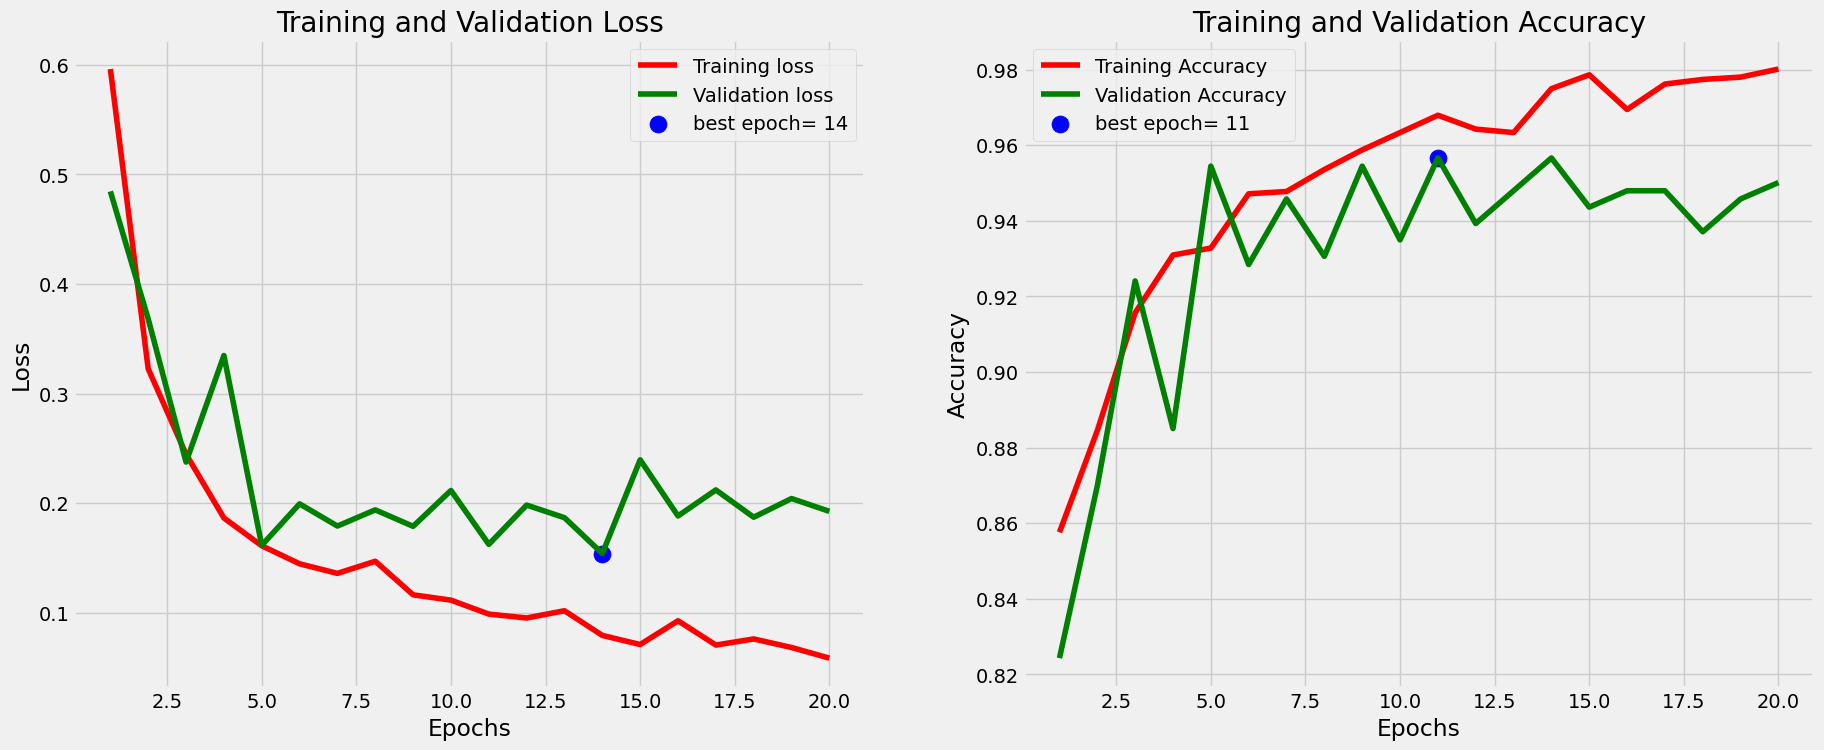

In [ ]:
tr_plot(history,0)

In [ ]:
# Recreate the train generator after modifying train_df
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Recreate the train_multi_input dataset
train_multi_input = tf.data.Dataset.from_generator(
    lambda: multiple_inputs_generator(train_gen),
    output_signature=output_signature
)

# Fine-tune the ensemble model
history_finetune = stacking_ensemble_model.fit(train_multi_input,
                            validation_data=valid_multi_input,
                            epochs=10,
                            steps_per_epoch=len(train_gen),
                            validation_steps=len(valid_gen),
                            verbose=0)

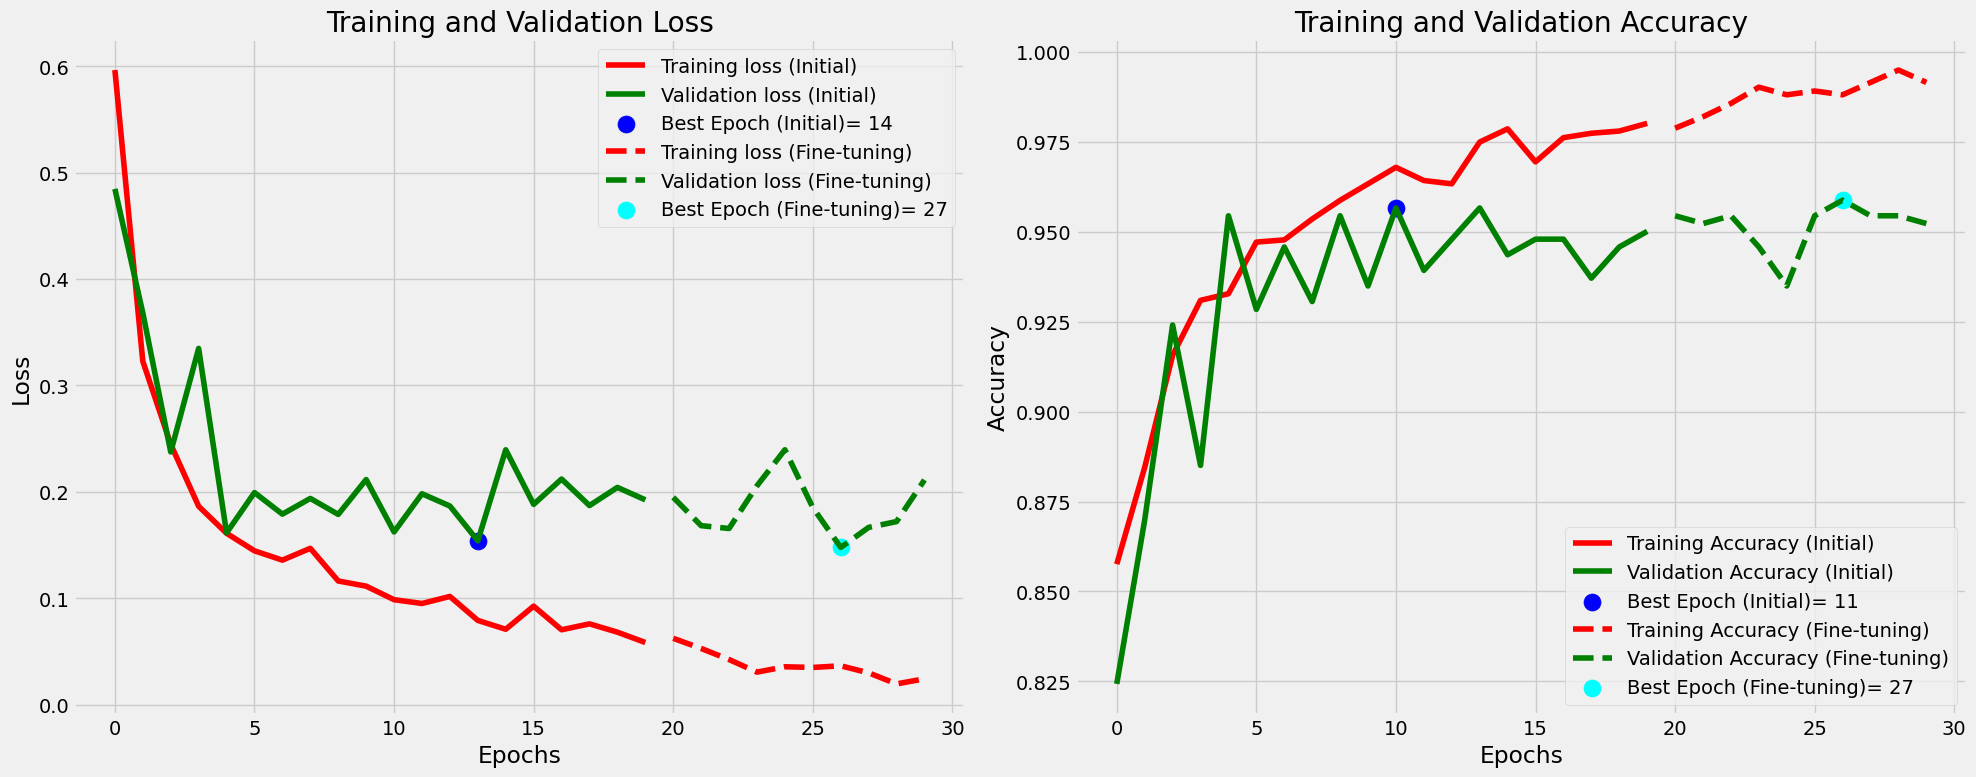

In [ ]:

def plot_combined_history(history1, history2, start_epoch1=0):
    # Extract data from both histories
    tacc1 = history1.history['accuracy']
    tloss1 = history1.history['loss']
    vacc1 = history1.history['val_accuracy']
    vloss1 = history1.history['val_loss']

    tacc2 = history2.history['accuracy']
    tloss2 = history2.history['loss']
    vacc2 = history2.history['val_accuracy']
    vloss2 = history2.history['val_loss']

    # Calculate epoch ranges
    epoch_count1 = len(tacc1) + start_epoch1
    epochs1 = range(start_epoch1, epoch_count1)
    epoch_count2 = len(tacc2) + epoch_count1
    epochs2 = range(epoch_count1, epoch_count2)

    # Find best epochs
    index_loss1 = np.argmin(vloss1)
    val_lowest1 = vloss1[index_loss1]
    index_acc1 = np.argmax(vacc1)
    acc_highest1 = vacc1[index_acc1]

    index_loss2 = np.argmin(vloss2)
    val_lowest2 = vloss2[index_loss2]
    index_acc2 = np.argmax(vacc2)
    acc_highest2 = vacc2[index_acc2]

    # Plotting
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Loss plot
    axes[0].plot(epochs1, tloss1, 'r', label='Training loss (Initial)')
    axes[0].plot(epochs1, vloss1, 'g', label='Validation loss (Initial)')
    axes[0].scatter(index_loss1 + start_epoch1, val_lowest1, s=150, c='blue',
                    label=f'Best Epoch (Initial)= {index_loss1 + 1 + start_epoch1}')

    axes[0].plot(epochs2, tloss2, 'r--', label='Training loss (Fine-tuning)')
    axes[0].plot(epochs2, vloss2, 'g--', label='Validation loss (Fine-tuning)')
    axes[0].scatter(index_loss2 + epoch_count1, val_lowest2, s=150, c='cyan',
                    label=f'Best Epoch (Fine-tuning)= {index_loss2 + 1 + epoch_count1}')

    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(epochs1, tacc1, 'r', label='Training Accuracy (Initial)')
    axes[1].plot(epochs1, vacc1, 'g', label='Validation Accuracy (Initial)')
    axes[1].scatter(index_acc1 + start_epoch1, acc_highest1, s=150, c='blue',
                    label=f'Best Epoch (Initial)= {index_acc1 + 1 + start_epoch1}')

    axes[1].plot(epochs2, tacc2, 'r--', label='Training Accuracy (Fine-tuning)')
    axes[1].plot(epochs2, vacc2, 'g--', label='Validation Accuracy (Fine-tuning)')
    axes[1].scatter(index_acc2 + epoch_count1, acc_highest2, s=150, c='cyan',
                    label=f'Best Epoch (Fine-tuning)= {index_acc2 + 1 + epoch_count1}')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the combined history
plot_combined_history(history, history_finetune)


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
There were 28 errors in 913 tests for an accuracy of 96.93


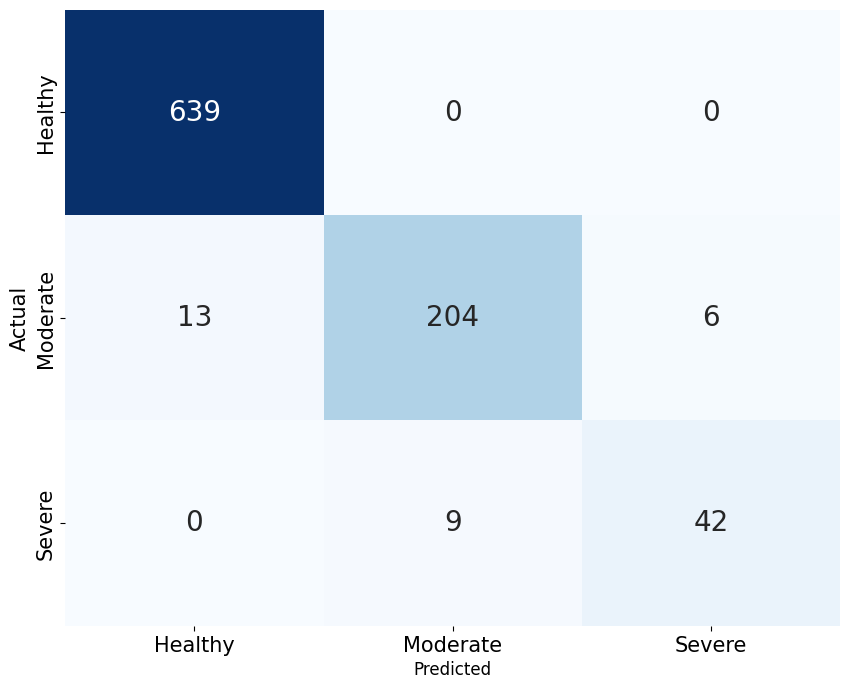


Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9801    1.0000    0.9899       639
    Moderate     0.9577    0.9148    0.9358       223
      Severe     0.8750    0.8235    0.8485        51

    accuracy                         0.9693       913
   macro avg     0.9376    0.9128    0.9247       913
weighted avg     0.9687    0.9693    0.9688       913



In [ ]:
def predictor(test_multi_input, test_steps):
    y_pred_probs = []  # Store probabilities for ROC curve
    y_pred= []
    y_true=test_multi_input.labels
    classes=list(test_multi_input.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model1.predict(test_multi_input, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        y_pred_probs.append(p)  # Store probabilities
        true_index=test_multi_input.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_multi_input.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
        plt.xticks(np.arange(class_count)+.5, classes, rotation=0, fontsize=15)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=90, fontsize=15)
        plt.xlabel("Predicted",fontsize=12)
        plt.ylabel("Actual", fontsize=15)
        # plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, np.array(y_pred_probs)  # Return probabilities

errors, tests, y_pred_probs = predictor(test_gen, test_steps)  # Get probabilities


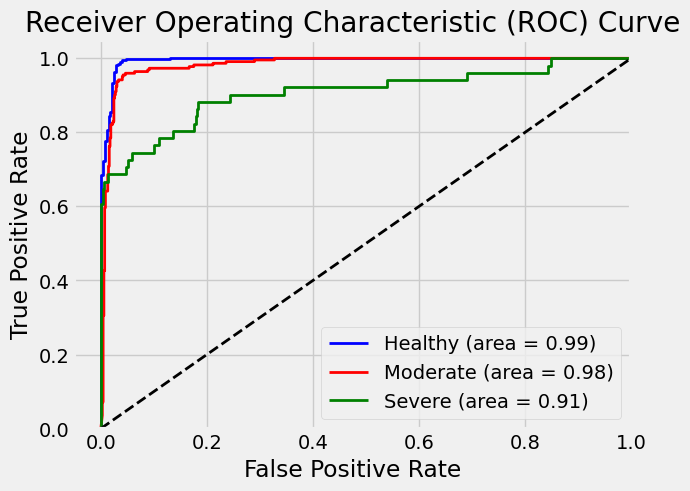

In [ ]:
# prompt: plot ROC curve for the ensemble model, write class names only

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true classes from the test generator
true_classes = test_gen.classes

# Binarize the true labels
y_true_bin = label_binarize(true_classes, classes=np.unique(true_classes))

# Assuming 'y_pred_probs' from your 'predictor' function contains the model predictions
predictions = y_pred_probs

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_count):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
class_labels = list(test_gen.class_indices.keys()) # Convert dict_keys to a list
for i, color in zip(range(class_count), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i])) # Use the list of class labels

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()